In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 📊 Trader Behavior vs Market Sentiment Analysis:

**Objective: Explore how trader performance and behavior shift based on market sentiment (Fear, Greed, Neutral)**

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

#  📥 Data Loading and Cleaning

In [3]:
# Load sentiment data
sentiment = pd.read_csv("drive/MyDrive/internship-task-data/fear_greed_index.csv", parse_dates=['date'])

# Simplify to 3-level sentiment
def simplify_sentiment(x):
    if 'Fear' in x:
        return 'Fear'
    elif 'Greed' in x:
        return 'Greed'
    else:
        return 'Neutral'

sentiment['Sentiment'] = sentiment['classification'].apply(simplify_sentiment)

In [7]:
# Load trade data
trades = pd.read_csv("drive/MyDrive/internship-task-data/historical_data.csv", low_memory=False)
trades['time'] = pd.to_datetime(trades['Timestamp IST'], dayfirst=True, errors='coerce')
trades['date'] = trades['time'].dt.date

# Convert the 'date' column in trades to datetime objects
trades['date'] = pd.to_datetime(trades['date'])

In [8]:
# Merge sentiment into trades
merged = trades.merge(sentiment[['date', 'Sentiment']], on='date', how='left')
merged.rename(columns={'Sentiment': 'Sentiment'}, inplace=True)

# 🧮 Feature Engineering

In [9]:
# Risk-related features
merged['avg_token_cost'] = merged['Size USD'] / merged['Size Tokens']
merged['price_deviation'] = abs(merged['avg_token_cost'] - merged['Execution Price'])
merged['risk_score'] = merged['Size USD'] * merged['price_deviation']

# PnL efficiency: PnL per $ spent
merged['pnl_efficiency'] = merged['Closed PnL'] / merged['Size USD']
merged['pnl_efficiency'].replace([np.inf, -np.inf], np.nan, inplace=True)


/tmp/ipython-input-9-2958790945.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged['pnl_efficiency'].replace([np.inf, -np.inf], np.nan, inplace=True)


# 📊 Visual Analysis

**1. PnL Distibution**

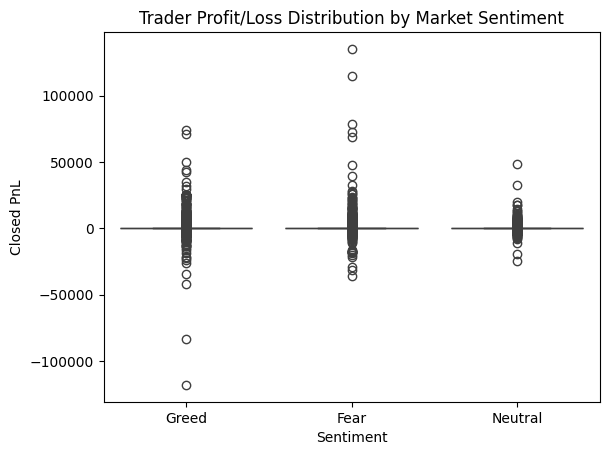

In [10]:
# 1. PnL Distribution
sns.boxplot(data=merged, x='Sentiment', y='Closed PnL')
plt.title("Trader Profit/Loss Distribution by Market Sentiment")
plt.show()


**Insight:**

---
**PnL Is Inconsistent Across Sentiments**

The distribution of Closed PnL shows wide variability in all sentiment categories.
There is no clear advantage in profitability during Greed or Fear. Traders seem to experience similar gains and losses, regardless of sentiment.


**2. Average Risk Score**

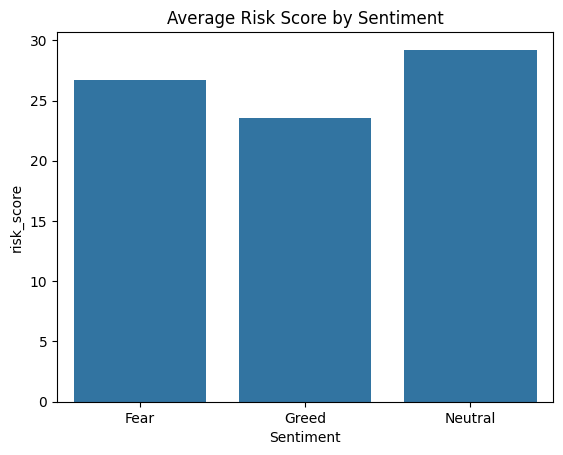

In [11]:
# 2. Average Risk Score
risk_plot = merged.groupby('Sentiment')['risk_score'].mean().reset_index()
sns.barplot(data=risk_plot, x='Sentiment', y='risk_score')
plt.title("Average Risk Score by Sentiment")
plt.show()


**Insight:**

---
**Risk Score is Surprisingly Highest During Neutral Sentiment**

Contrary to expectations, traders took on higher risk scores during Neutral and Fear periods, and were most conservative during Greed.
This may suggest that traders take speculative positions when sentiment is unclear, while Greed phases trigger smaller, more confident trades.


**3. Trade Direction by Sentiment**

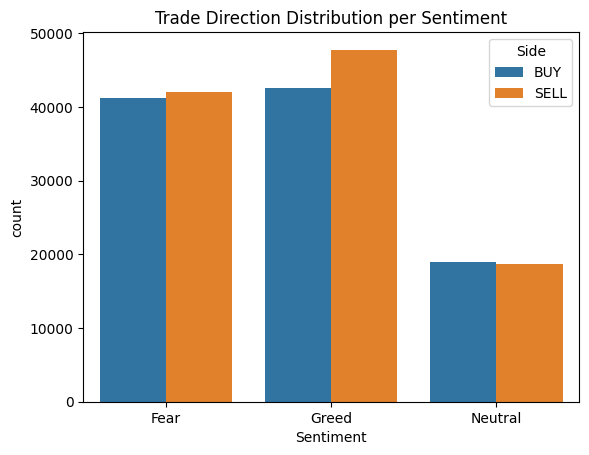

In [12]:
# 3. Trade Direction by Sentiment
side_counts = merged.groupby(['Sentiment', 'Side']).size().reset_index(name='count')
sns.barplot(data=side_counts, x='Sentiment', y='count', hue='Side')
plt.title("Trade Direction Distribution per Sentiment")
plt.show()

**Insight:**

---
**Trade Direction is Sentiment-Influenced**

During Greed, there’s a noticeable spike in SELL trades, surpassing BUYs, possibly reflecting profit-booking behavior.
In contrast, BUY and SELL activity is nearly balanced during Fear, and drops significantly during Neutral, indicating reduced market participation in uncertain conditions.


**4. Top Coins by Sentiment**

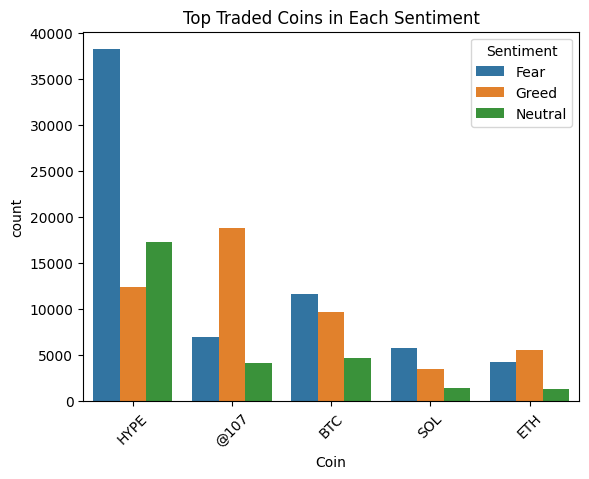

In [14]:
# 4. Top Coins by Sentiment
top_coins = merged.groupby(['Sentiment', 'Coin']).size().reset_index(name='count')
top_coins = top_coins.sort_values('count', ascending=False).groupby('Sentiment').head(5)
sns.barplot(data=top_coins, x='Coin', y='count', hue='Sentiment')
plt.title("Top Traded Coins in Each Sentiment")
plt.xticks(rotation=45)
plt.show()

**Insight:**

---
**Trading Activity Is Heavily Concentrated Around Specific Coins in Certain Sentiments**


*   HYPE dominates during Fear, suggesting it might be a speculative favorite or high-volatility asset.

*   @107 is most traded during Greed, which could reflect strategic targeting of high-performing coins.
*   BTC and SOL show fairly balanced activity across sentiments, suggesting they are core assets for consistent trading.








**5. PnL Efficiency**

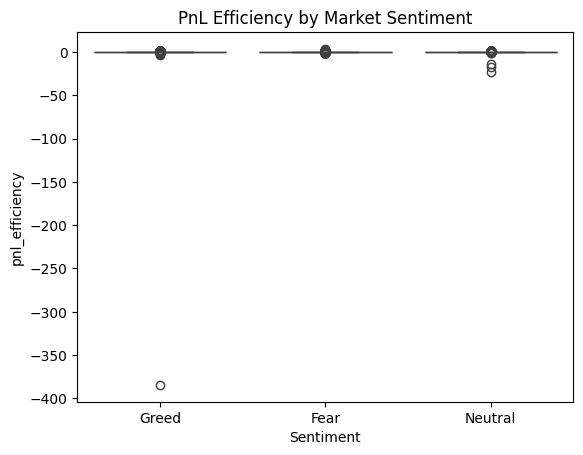

In [15]:
# 5. PnL Efficiency
sns.boxplot(data=merged, x='Sentiment', y='pnl_efficiency')
plt.title("PnL Efficiency by Market Sentiment")
plt.show()

**Insight:**

---
**PnL Efficiency is Volatile and Worst in Greed**

The pnl_efficiency plot shows that Greed has the lowest efficiency outliers, with some traders taking huge losses per dollar invested.
This could indicate overconfidence or crowded trades during bullish sentiment that result in poor returns.


**6. PnL Volatility**

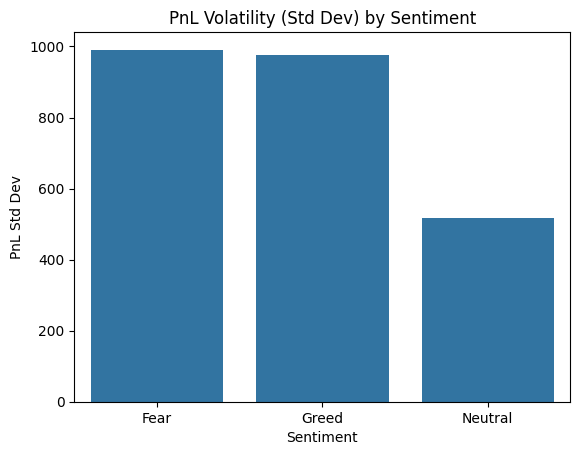

In [16]:
# 6. PnL Volatility
pnl_std = merged.groupby('Sentiment')['Closed PnL'].std().reset_index()
sns.barplot(data=pnl_std, x='Sentiment', y='Closed PnL')
plt.title("PnL Volatility (Std Dev) by Sentiment")
plt.ylabel("PnL Std Dev")
plt.show()

**Insight:**

---
**PnL Volatility Is Highest During Fear and Greed**

Standard deviation of PnL is highest in Fear (990) and very close in Greed (~970), with Neutral showing much lower volatility (500).
This supports the view that emotional market states (Fear or Greed) lead to greater unpredictability in trade outcomes.


**🔬 Statistical Testing**

In [17]:
fear_pnl = merged[merged['Sentiment'] == 'Fear']['Closed PnL']
greed_pnl = merged[merged['Sentiment'] == 'Greed']['Closed PnL']
t_stat, p_val = ttest_ind(fear_pnl, greed_pnl, equal_var=False)
print(f"T-statistic: {t_stat:.4f}, P-value: {p_val:.4f}")


T-statistic: -0.9875, P-value: 0.3234


**Insight:**

---
No Statistically Significant Difference in Avg PnL

A two-sample t-test between Fear and Greed yields:
T-statistic = -0.9875, P-value = 0.3234
 Interpretation: No statistically significant difference in average PnL between Fear and Greed conditions.
This confirms that behavior changes (risk, volume, direction) are more sentiment-linked than performance.


# 📘 Final Insights



1.    PnL distribution does not significantly vary across sentiment phases.
2. Risk-taking behavior peaks in Neutral conditions, not Greed.
3. PnL efficiency is worst in Greed, indicating possible overconfidence.
4. Fear and Greed cause higher volatility in trading outcomes.
5. T-test confirms no statistically significant difference in mean PnL between Fear and Greed.
6. More SELL trades happen during Greed; BUYs dominate or balance out during Fear.
7. Specific coins like HYPE and @107 are traded more during distinct sentiments, while BTC remains steady across moods.


8.   **Sentiment-Aware Strategies Could Reduce Risk and Improve Entry Timing:**

      The data suggests that trading behavior shifts with sentiment — not necessarily performance.
      By integrating the Fear-Greed Index into strategy logic (e.g., scaling down trades in Neutral), traders may better manage risk exposure, avoid overtrading in uncertain times, and exploit behavioral patterns in specific coins.

9.   Our analysis reveals not just how traders perform, but how their behavior, asset preferences, and risk posture adapt to market sentiment. By quantifying these patterns, we open up new possibilities for building sentiment-aware trading models.


